In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pygmt
from obspy.core import UTCDateTime

In [2]:
# Read in features, look at names & datatypes
df_original = pd.read_csv('p_features.csv', dtype={'location_code': str})
print(len(df_original))
print(df_original.dtypes)

72952
arrival_identifier                int64
avg_noise_1.00                  float64
avg_noise_10.00                 float64
avg_noise_11.00                 float64
avg_noise_12.00                 float64
avg_noise_13.00                 float64
avg_noise_14.00                 float64
avg_noise_15.00                 float64
avg_noise_16.00                 float64
avg_noise_17.00                 float64
avg_noise_18.00                 float64
avg_noise_2.00                  float64
avg_noise_3.00                  float64
avg_noise_4.00                  float64
avg_noise_5.00                  float64
avg_noise_6.00                  float64
avg_noise_7.00                  float64
avg_noise_8.00                  float64
avg_noise_9.00                  float64
avg_signal_1.00                 float64
avg_signal_10.00                float64
avg_signal_11.00                float64
avg_signal_12.00                float64
avg_signal_13.00                float64
avg_signal_14.00                fl

In [3]:
# This catalog of events seems to be missing 2 events 60055267, 60071327
# ngb_event_df = pd.read_csv("NGB_events_201309_201407.csv")
# ngb_event_df

# df_ngb_old = df_original[np.isin(df_original.event_identifier, ngb_event_df.evid)]

In [4]:
# Get metadata for 1 and 3c stations
eq_meta_onec = pd.read_csv("currentEarthquakeArrivalInformation1CWithGains.csv")
eq_meta_threec = pd.read_csv("currentEarthquakeArrivalInformation3CWithGains.csv")
eq_meta_all = pd.concat([eq_meta_onec, eq_meta_threec])

# Reduce to just location information
all_eq_locs = eq_meta_all.drop_duplicates("evid")[["evid", "event_lat", "event_lon", "origin_time"]]
all_eq_locs.columns = ["event_identifier", "event_lat", "event_lon", "origin_time"]

# Reduce to events in the dataset 
eq_locs_df = all_eq_locs[np.isin(all_eq_locs.event_identifier, df_original.event_identifier.unique())]
# Make date column for filtering
eq_locs_df.loc[:, "date"] = eq_locs_df.origin_time.apply(lambda x: int(UTCDateTime(x).strftime("%y%m%d")))

/tmp/ipykernel_5212/2636885443.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  eq_meta_threec = pd.read_csv("currentEarthquakeArrivalInformation3CWithGains.csv")
/tmp/ipykernel_5212/2636885443.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eq_locs_df.loc[:, "date"] = eq_locs_df.origin_time.apply(lambda x: int(UTCDateTime(x).strftime("%y%m%d")))


In [5]:
# Set filter bounds
lat_min = 44.680
lat_max = 44.870
lon_max = 110.850
lon_min = 110.640
date_min = 130901  # YYMMDD
date_max = 140630  # YYMMDD
bounds = {"lat_min": lat_min,
          "lat_max": lat_max,
          "lon_max": lon_max,
          "lon_min": lon_min,
          "date_min": date_min,
          "date_max": date_max}

# Get ngb event ids
ngb_event_locs = eq_locs_df.loc[
        (eq_locs_df["date"] >= bounds["date_min"]) & (eq_locs_df["date"] <= bounds["date_max"]) & (eq_locs_df["event_lat"] >= bounds["lat_min"])
        & (eq_locs_df["event_lat"] <= bounds["lat_max"]) & (-1 * eq_locs_df["event_lon"] >= bounds["lon_min"]) & (
                    -1 * eq_locs_df["event_lon"] <= bounds["lon_max"])]

In [6]:
df_ngb_removed = df_original[~np.isin(df_original.event_identifier, ngb_event_locs.event_identifier)]
df_ngb = df_original[np.isin(df_original.event_identifier, ngb_event_locs.event_identifier)]
np.where(np.isin(df_ngb_removed.event_identifier, df_ngb.event_identifier))

(array([], dtype=int64),)

In [7]:
# Read in park and caldera boundaries
utahnet_path = "../maps/utahnet"
ys_border = pd.read_csv(f"{utahnet_path}/yell.border.g", delimiter=" ", names=["Longitude", "Latitude"], dtype=np.float64)
caldera = pd.read_csv(f"{utahnet_path}/caldera.ys", sep="\s+", names=["Latitude", "Longitude"], dtype=np.float64)

caldera = caldera.drop(caldera[caldera["Longitude"]==0].index)
caldera = caldera[["Longitude", "Latitude"]]
caldera["Longitude"] = caldera["Longitude"]*-1

In [8]:
# Lat/lon bounding box I could use to scale the source locations
bb_lat_min = ys_border.Latitude.min() - 0.2
bb_lat_max = ys_border.Latitude.max()
bb_lon_min = ys_border.Longitude.min() - 0.15
bb_lon_max = ys_border.Longitude.max()
ys_bb = [[bb_lon_max, bb_lat_max], [bb_lon_max, bb_lat_min], [bb_lon_min, bb_lat_min], [bb_lon_min, bb_lat_max], [bb_lon_max, bb_lat_max]]

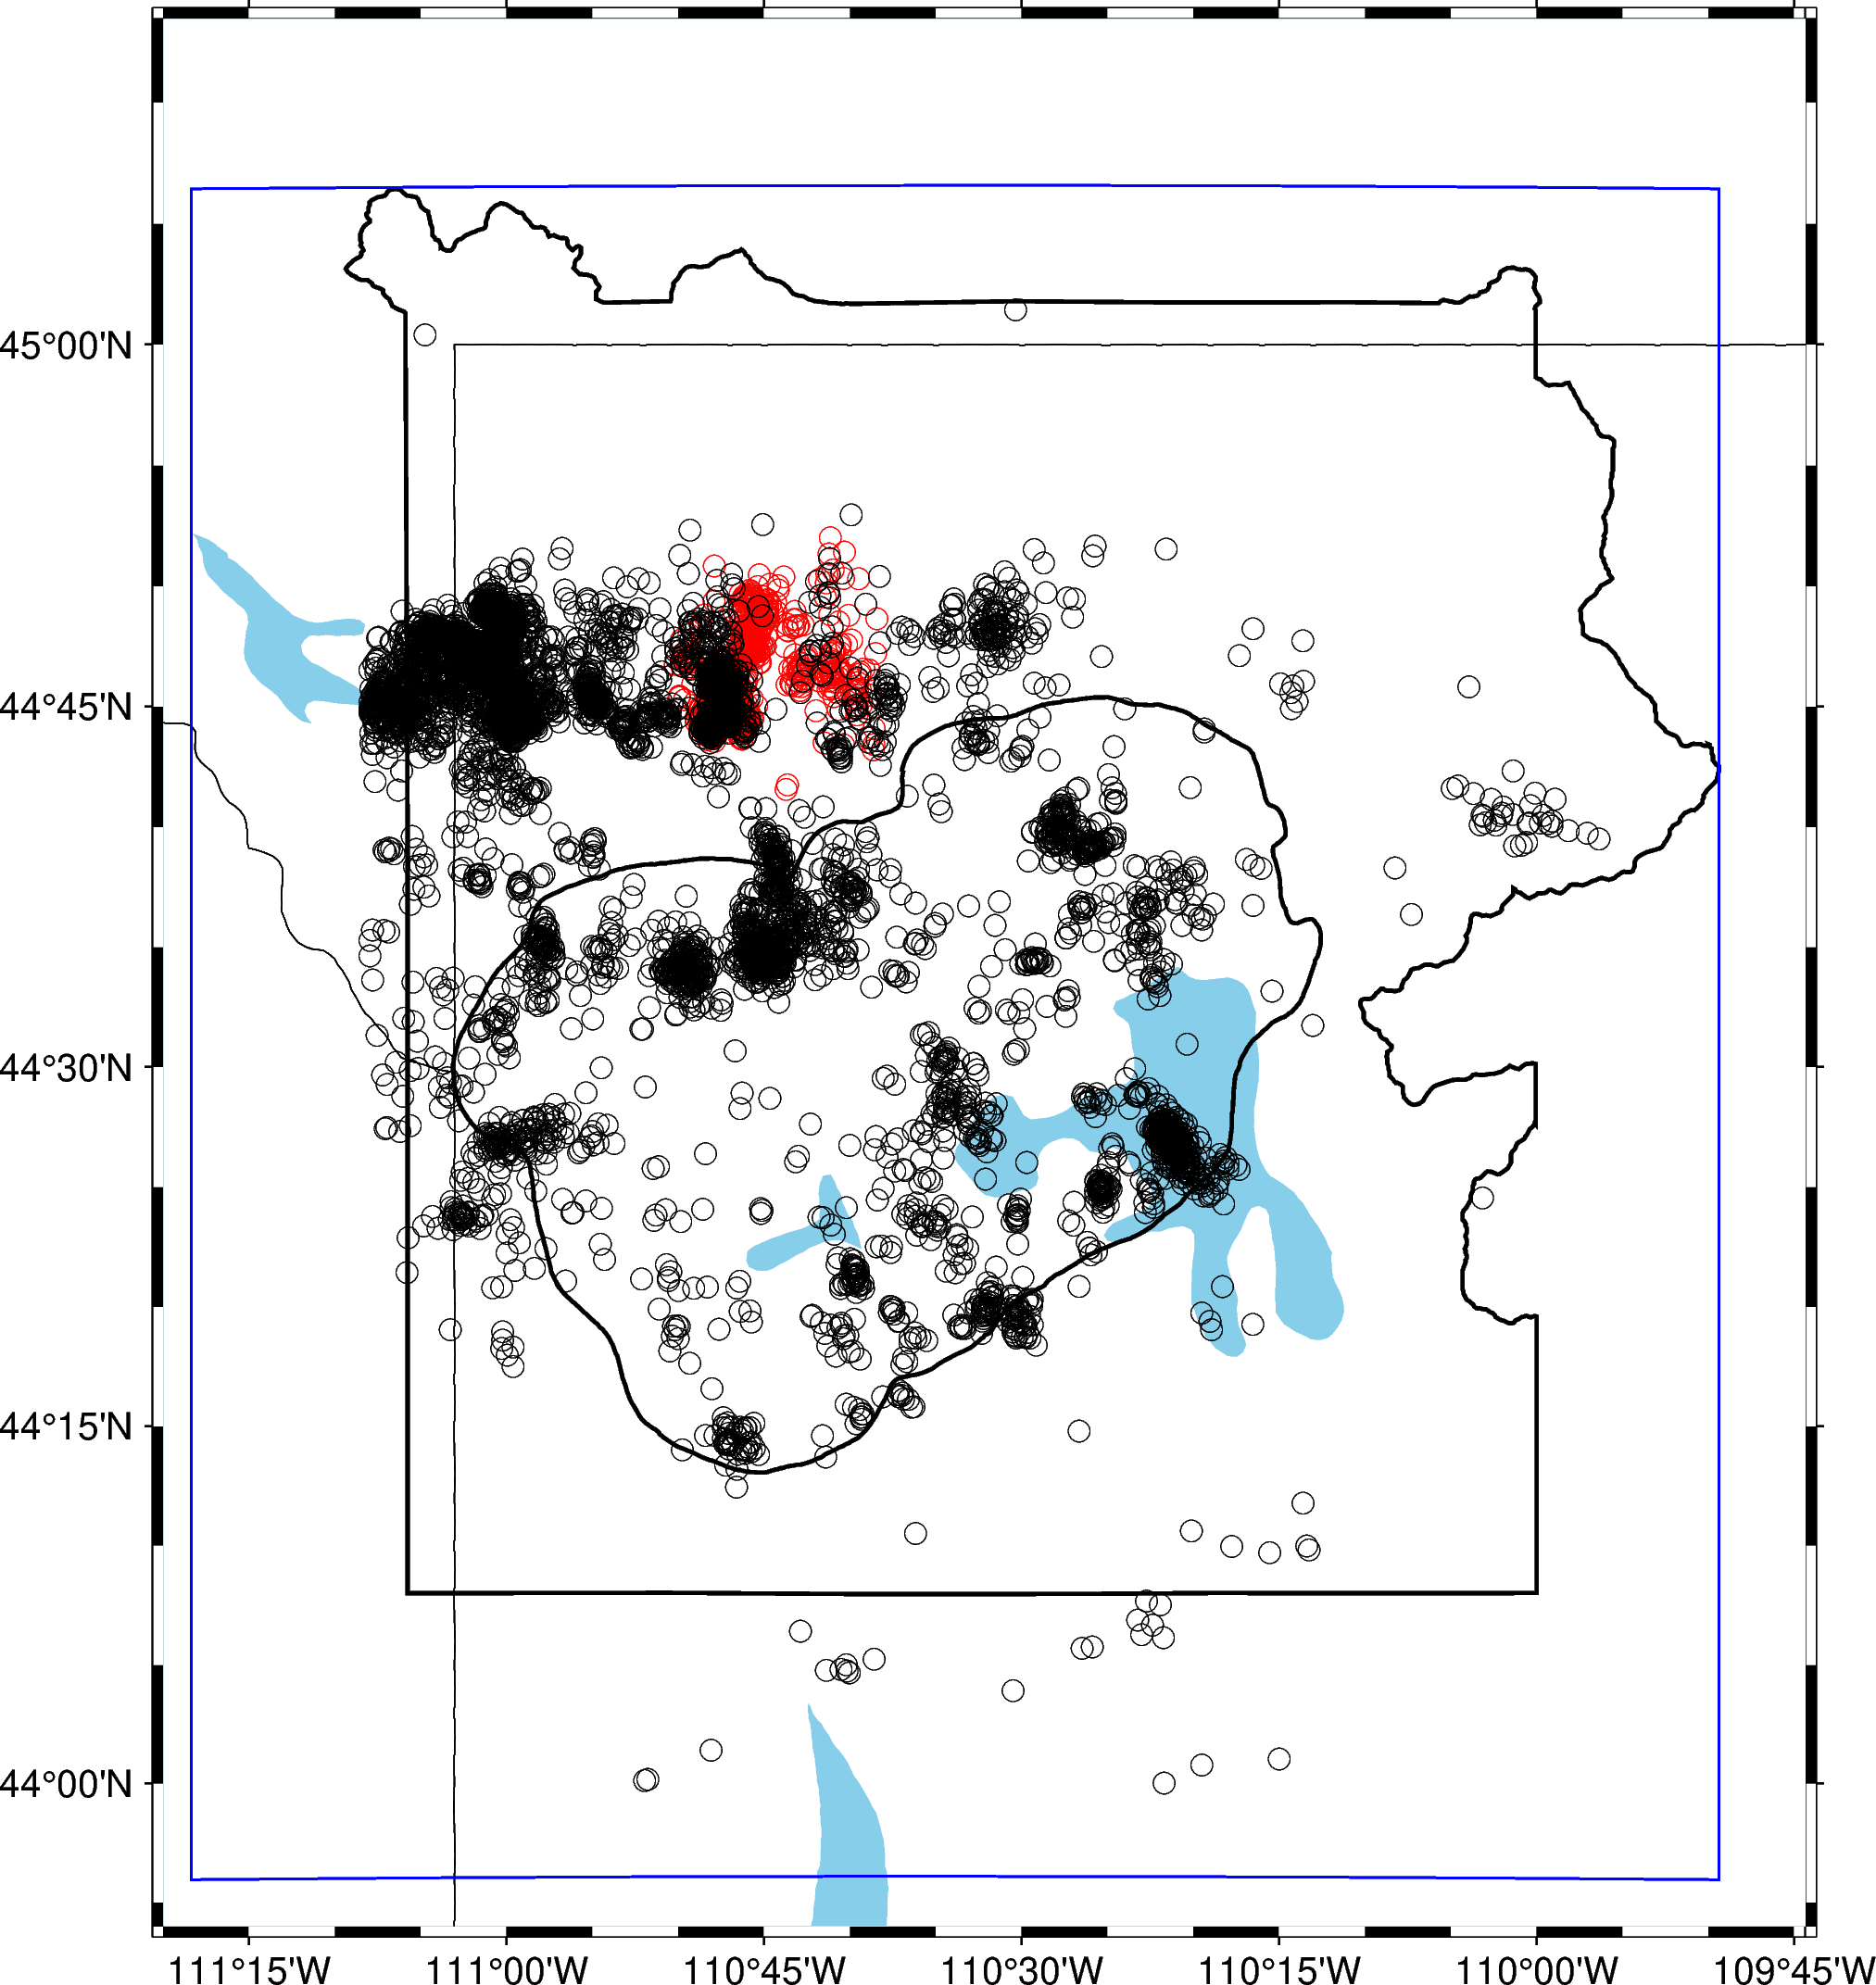

In [9]:
#Draw event map 
region = [
    eq_locs_df.event_lon.min() - 0.2,
    eq_locs_df.event_lon.max() + 0.2,
    eq_locs_df.event_lat.min() - 0.1,
    eq_locs_df.event_lat.max() + 0.2,
]

unique_locations = df_ngb_removed[["source_longitude", "source_latitude"]].drop_duplicates()
unique_ngb_locations = df_ngb[["source_longitude", "source_latitude"]].drop_duplicates()

fig = pygmt.Figure()
fig.basemap(region=region, projection="M15c", frame=True)
fig.coast(land="white", borders=2, water="skyblue")
fig.plot(data=ys_border, pen="1.0p,black")
fig.plot(data=caldera, pen='1.0p,black')
fig.plot(x=unique_ngb_locations.source_longitude, y=unique_ngb_locations.source_latitude, style="c0.2c", pen="0.2p,red")
fig.plot(x=unique_locations.source_longitude, y=unique_locations.source_latitude, style="c0.2c", pen="0.2p,black")
fig.plot(ys_bb, pen="0.6p,blue")
fig.show()

In [10]:
# Keep stations with more than 350 observations
stat_counts = df_original.value_counts("station").to_frame().reset_index()
stat_counts.columns = ["Station", "Count"]
df_org_filtcounts = df_ngb_removed[np.isin(df_ngb_removed.station, stat_counts[stat_counts.Count >= 350])]

## Feature selection?

In [11]:
# Make train and test datasets

test_size = 0.2
station = "YNR"

station_df = df_org_filtcounts[df_org_filtcounts.station == station]

evids = np.unique(station_df.event_identifier)
train_evids, test_evids = train_test_split(evids, test_size = test_size, random_state = 843823)

train_inds = np.isin(station_df.event_identifier, train_evids)
train_df = station_df[train_inds]
test_df = station_df[~train_inds]

assert len(train_df.event_identifier.unique()) == len(train_evids)
assert len(test_df.event_identifier.unique()) == len(test_evids)
assert len(test_df) + len(train_df) == len(station_df)

In [12]:
# Computes the feature matrix from a dataframe
def compute_feature_df(df, scaler = True):
    # Loosely speaking empirical magnitudes look like:
    # M = log10(A) + Q(Delta) 
    # where A is the amplitude and Q a distance dependent correction term.
    # Additionally, the difference between log10 and log amounts to a scalar
    # that a machine can learn.
    # Basically, I'm interested in features that:
    #   (1) Measure size in, potentially, different amplitudes.
    # different `passbands' deviates from the noise, 
    n_rows = len(df)
    n_columns = 48
    X = np.zeros([n_rows, n_columns])
    # Get a proxy on size
    
    # These are effectively amplitude ratios.  Note,
    # log(a/b) = log(a) - log(b)
    X[:,0]  = np.log(df['avg_signal_1.00']) - np.log(df['avg_noise_1.00'])
    X[:,1]  = np.log(df['avg_signal_2.00']) - np.log(df['avg_noise_2.00'])
    X[:,2]  = np.log(df['avg_signal_3.00']) - np.log(df['avg_noise_3.00'])
    X[:,3]  = np.log(df['avg_signal_4.00']) - np.log(df['avg_noise_4.00'])
    X[:,4]  = np.log(df['avg_signal_5.00']) - np.log(df['avg_noise_5.00'])
    X[:,5]  = np.log(df['avg_signal_6.00']) - np.log(df['avg_noise_6.00'])
    X[:,6]  = np.log(df['avg_signal_7.00']) - np.log(df['avg_noise_7.00'])
    X[:,7]  = np.log(df['avg_signal_8.00']) - np.log(df['avg_noise_8.00'])
    X[:,8]  = np.log(df['avg_signal_9.00']) - np.log(df['avg_noise_9.00'])
    X[:,9]  = np.log(df['avg_signal_10.00']) - np.log(df['avg_noise_10.00'])
    X[:,10] = np.log(df['avg_signal_11.00']) - np.log(df['avg_noise_11.00'])
    X[:,11] = np.log(df['avg_signal_12.00']) - np.log(df['avg_noise_12.00'])
    X[:,12] = np.log(df['avg_signal_13.00']) - np.log(df['avg_noise_13.00'])
    X[:,13] = np.log(df['avg_signal_14.00']) - np.log(df['avg_noise_14.00'])
    X[:,14] = np.log(df['avg_signal_15.00']) - np.log(df['avg_noise_15.00'])
    X[:,15] = np.log(df['avg_signal_16.00']) - np.log(df['avg_noise_16.00'])
    X[:,16] = np.log(df['avg_signal_17.00']) - np.log(df['avg_noise_17.00'])
    X[:,17] = np.log(df['avg_signal_18.00']) - np.log(df['avg_noise_18.00'])
    # Look at amplitudes
    X[:,18] = np.log(df['avg_signal_1.00']) 
    X[:,19] = np.log(df['avg_signal_2.00']) 
    X[:,20] = np.log(df['avg_signal_3.00']) 
    X[:,21] = np.log(df['avg_signal_4.00']) 
    X[:,22] = np.log(df['avg_signal_5.00'])
    X[:,23] = np.log(df['avg_signal_6.00'])
    X[:,24] = np.log(df['avg_signal_7.00'])
    X[:,25] = np.log(df['avg_signal_8.00'])
    X[:,26] = np.log(df['avg_signal_9.00'])
    X[:,27] = np.log(df['avg_signal_10.00'])
    X[:,28] = np.log(df['avg_signal_11.00'])
    X[:,29] = np.log(df['avg_signal_12.00'])
    X[:,30] = np.log(df['avg_signal_13.00'])
    X[:,31] = np.log(df['avg_signal_14.00'])
    X[:,32] = np.log(df['avg_signal_15.00'])
    X[:,33] = np.log(df['avg_signal_16.00'])
    X[:,34] = np.log(df['avg_signal_17.00'])
    X[:,35] = np.log(df['avg_signal_18.00'])
    # Frequency and max amplitude
    X[:,36] = np.log(df['signal_dominant_frequency'])
    X[:,37] = np.log(df['signal_dominant_amplitude'])
    # Time-based featuers: Look at max amplitudes of noise/signal
    X[:,38] = np.log(df['noise_maximum_value']  - df['noise_minimum_value'])
    X[:,39] = np.log(df['signal_maximum_value'] - df['signal_minimum_value'])
    X[:,40] = np.log(df['signal_variance'])
    X[:,41] = np.log(df['noise_variance'])
    # Source/recv distance (take log to flatten this)
    X[:,42] = np.log(df['source_receiver_distance_km'])
    X[:,43] = df['source_depth_km']
    # Single stations can learn location
    X[:,44] = df['source_latitude']
    X[:,45] = df['source_longitude']
    X[:,46] = np.sin(df['source_receiver_back_azimuth'])
    X[:,47] = df['source_receiver_back_azimuth']

    
    # Standardize features
    if (scaler):
        scaler = StandardScaler()
        scaler = scaler.fit(X)
        X = scaler.transform(X)
        return X, scaler
    
    return X
    
#X, scaler = compute_feature_matrix(df)

In [13]:
train_feat_matrix_scaled, scaler = compute_feature_df(train_df)
train_feat_matrix_unscaled = compute_feature_df(train_df, scaler=False)

train_y = train_df.magnitude.values

In [14]:
train_feat_matrix_scaled[0], train_feat_matrix_unscaled[0]

(array([ 1.81335314,  0.84960982,  1.43179994,  1.19563459,  0.52969987,
        -0.36461194, -0.68864504, -0.75263395, -0.75677581, -0.7195594 ,
        -0.69514561, -0.71428606, -0.71541888, -0.68451884, -0.64897372,
        -0.61732443, -0.59269037, -0.57998005,  2.80073673,  1.86032406,
         1.87643718,  1.54373157,  0.98449291,  0.502731  ,  0.30299436,
         0.24142232,  0.20269387,  0.16820796,  0.1096196 ,  0.02244586,
        -0.04938522, -0.07907677, -0.07793168, -0.06611791, -0.05312792,
        -0.04405737, -4.03307982,  0.81938864,  2.15928381,  0.45411585,
         0.74691447,  1.91323555,  1.53235692,  1.97599049, -2.7323048 ,
        -0.88037617, -0.90485412, -0.31082953]),
 array([   2.91911297,    2.4089576 ,    3.31309329,    3.42328096,
           3.02747131,    2.31886496,    2.1994042 ,    2.41542596,
           2.65745246,    2.87601498,    3.04400326,    3.1393346 ,
           3.22839125,    3.32875621,    3.4125859 ,    3.47531788,
           3.51756978,

In [15]:
train_y

array([3.16, 2.5 , 2.  , ..., 1.93, 1.63, 1.79])

In [16]:
train_feat_df = pd.DataFrame(train_feat_matrix_scaled, columns=["amp_ratio_01.0", "amp_ratio_02.0", "amp_ratio_03.0", "amp_ratio_04.0", 
                                 "amp_ratio_05.0", "amp_ratio_06.0", "amp_ratio_07.0", "amp_ratio_08.0",
                                 "amp_ratio_09.0", "amp_ratio_10.0", "amp_ratio_11.0", "amp_ratio_12.0", 
                                 "amp_ratio_13.0", "amp_ratio_14.0", "amp_ratio_15.0", "amp_ratio_16.0", 
                                 "amp_ratio_17.0", "amp_ratio_18.0", 
                                 "amp_01.0", "amp_02.0", "amp_03.0", "amp_04.0", 
                                 "amp_05.0", "amp_06.0", "amp_07.0", "amp_08.0",
                                 "amp_09.0", "amp_10.0", "amp_11.0", "amp_12.0", 
                                 "amp_13.0", "amp_14.0", "amp_15.0", "amp_16.0", 
                                 "amp_17.0", "amp_18.0",
                                 "signal_dominant_frequency", "signal_dominant_amplitude", 
                                 "noise_max_amplitude", "signal_max_amplitude", "signal_variance", "noise_variance",
                                 "source_receiver_distance_logkm", "source_depth_km","source_latitude", "source_longitude", 
                                 "sin_receiver_back_azimuth", "receiver_back_azimuth"])

In [17]:
train_feat_df_unscaled = pd.DataFrame(train_feat_matrix_unscaled, columns=["amp_ratio_01.0", "amp_ratio_02.0", "amp_ratio_03.0", "amp_ratio_04.0", 
                                 "amp_ratio_05.0", "amp_ratio_06.0", "amp_ratio_07.0", "amp_ratio_08.0",
                                 "amp_ratio_09.0", "amp_ratio_10.0", "amp_ratio_11.0", "amp_ratio_12.0", 
                                 "amp_ratio_13.0", "amp_ratio_14.0", "amp_ratio_15.0", "amp_ratio_16.0", 
                                 "amp_ratio_17.0", "amp_ratio_18.0", 
                                 "amp_01.0", "amp_02.0", "amp_03.0", "amp_04.0", 
                                 "amp_05.0", "amp_06.0", "amp_07.0", "amp_08.0",
                                 "amp_09.0", "amp_10.0", "amp_11.0", "amp_12.0", 
                                 "amp_13.0", "amp_14.0", "amp_15.0", "amp_16.0", 
                                 "amp_17.0", "amp_18.0",
                                 "signal_dominant_frequency", "signal_dominant_amplitude", 
                                 "noise_max_amplitude", "signal_max_amplitude", "signal_variance", "noise_variance",
                                 "source_receiver_distance_logkm", "source_depth_km","source_latitude", "source_longitude", 
                                 "sin_receiver_back_azimuth", "receiver_back_azimuth"])

In [18]:
feat_target_df = train_feat_df.copy()
feat_target_df.loc[:, "magnitude"] = train_y
corr = feat_target_df.corr()
corr.style.background_gradient(cmap="coolwarm")

,amp_ratio_01.0,amp_ratio_02.0,amp_ratio_03.0,amp_ratio_04.0,amp_ratio_05.0,amp_ratio_06.0,amp_ratio_07.0,amp_ratio_08.0,amp_ratio_09.0,amp_ratio_10.0,amp_ratio_11.0,amp_ratio_12.0,amp_ratio_13.0,amp_ratio_14.0,amp_ratio_15.0,amp_ratio_16.0,amp_ratio_17.0,amp_ratio_18.0,amp_01.0,amp_02.0,amp_03.0,amp_04.0,amp_05.0,amp_06.0,amp_07.0,amp_08.0,amp_09.0,amp_10.0,amp_11.0,amp_12.0,amp_13.0,amp_14.0,amp_15.0,amp_16.0,amp_17.0,amp_18.0,signal_dominant_frequency,signal_dominant_amplitude,noise_max_amplitude,signal_max_amplitude,signal_variance,noise_variance,source_receiver_distance_logkm,source_depth_km,source_latitude,source_longitude,sin_receiver_back_azimuth,receiver_back_azimuth,magnitude
amp_ratio_01.0,1.000000,0.750955,0.640405,0.571107,0.524419,0.504911,0.490370,0.464650,0.430359,0.397611,0.366040,0.335356,0.309645,0.291038,0.278453,0.269961,0.264081,0.259819,0.606635,0.591570,0.529418,0.498298,0.478968,0.474628,0.466972,0.450357,0.431149,0.414762,0.399630,0.384428,0.371436,0.362281,0.356369,0.352626,0.350298,0.348880,-0.236852,0.436935,-0.117124,0.425969,0.443622,-0.150531,-0.144718,-0.148294,-0.189727,0.288465,-0.011261,-0.189199,0.471477
amp_ratio_02.0,0.750955,1.000000,0.827265,0.728293,0.689953,0.681896,0.664930,0.626113,0.581367,0.545774,0.516288,0.487068,0.460570,0.440394,0.426408,0.417055,0.410815,0.406610,0.492882,0.708249,0.639335,0.597377,0.585725,0.595981,0.591647,0.570827,0.549597,0.535396,0.524733,0.512775,0.500936,0.491907,0.485980,0.482393,0.480421,0.479507,-0.156134,0.554720,-0.172155,0.551335,0.565055,-0.206028,-0.318465,-0.202315,-0.164150,0.353187,-0.006833,-0.208356,0.436740
amp_ratio_03.0,0.640405,0.827265,1.000000,0.896326,0.826339,0.807817,0.794579,0.767141,0.732172,0.703123,0.678227,0.651875,0.626631,0.606628,0.592212,0.582178,0.575182,0.570269,0.545740,0.735314,0.779484,0.736839,0.716854,0.723502,0.721990,0.707729,0.691740,0.680609,0.672183,0.662255,0.651872,0.643683,0.638078,0.634496,0.632375,0.631239,-0.079379,0.689257,-0.093037,0.690961,0.703827,-0.113991,-0.404264,-0.188833,-0.046865,0.285868,-0.005773,-0.123922,0.486986
amp_ratio_04.0,0.571107,0.728293,0.896326,1.000000,0.950290,0.902268,0.876488,0.849473,0.817849,0.792207,0.771255,0.748617,0.726337,0.708214,0.694853,0.685346,0.678606,0.673743,0.599018,0.771431,0.815352,0.829888,0.818567,0.812451,0.804593,0.790170,0.774596,0.763770,0.756105,0.747353,0.738001,0.730264,0.724686,0.720916,0.718517,0.717083,-0.062456,0.776851,-0.038990,0.777288,0.787354,-0.052329,-0.429643,-0.187262,0.001472,0.302350,0.007003,-0.154128,0.557284
amp_ratio_05.0,0.524419,0.689953,0.826339,0.950290,1.000000,0.973015,0.937459,0.903732,0.869519,0.842949,0.821712,0.799102,0.777025,0.758990,0.745658,0.736166,0.729442,0.724605,0.615591,0.788360,0.821167,0.844191,0.860628,0.859971,0.849162,0.832733,0.816485,0.805732,0.798427,0.790110,0.781141,0.773649,0.768189,0.764455,0.762048,0.760593,-0.035861,0.816182,-0.010089,0.817299,0.825510,-0.018315,-0.455878,-0.181512,0.026126,0.312913,0.021100,-0.185638,0.569009
amp_ratio_06.0,0.504911,0.681896,0.807817,0.902268,0.973015,1.000000,0.983012,0.945751,0.906511,0.877118,0.853928,0.829491,0.805716,0.786340,0.772125,0.762099,0.755071,0.750099,0.610548,0.792917,0.821776,0.837256,0.860860,0.879222,0.876142,0.858860,0.841562,0.830771,0.823736,0.815431,0.806180,0.798395,0.792740,0.788914,0.786484,0.785050,-0.009480,0.833265,0.003581,0.836475,0.843221,-0.002276,-0.490444,-0.171114,0.018712,0.299908,0.025484,-0.178382,0.548337
amp_ratio_07.0,0.490370,0.664930,0.794579,0.876488,0.937459,0.983012,1.000000,0.983085,0.950038,0.920831,0.896103,0.870127,0.845092,0.824727,0.809779,0.799206,0.791757,0.786450,0.607808,0.791935,0.822721,0.834906,0.856623,0.881390,0.891070,0.883149,0.869882,0.860165,0.853081,0.844687,0.835512,0.827857,0.822290,0.818474,0.815983,0.814437,0.028217,0.851057,0.008711,0.856041,0.862768,0.006176,-0.494698,-0.155404,0.056481,0.265102,0.023166,-0.152207,0.553107
amp_ratio_08.0,0.464650,0.626113,0.767141,0.849473,0.903732,0.945751,

In [19]:
from sklearn.feature_selection import mutual_info_regression, SequentialFeatureSelector, RFE

In [20]:
mutual_reg = mutual_info_regression(train_feat_matrix_scaled, train_y, random_state=843824)
mutual_reg

array([0.12717508, 0.1293338 , 0.15745474, 0.20615244, 0.20573871,
       0.20213107, 0.19955905, 0.22965652, 0.24678274, 0.22225474,
       0.23603925, 0.22686449, 0.18212504, 0.19643278, 0.16872744,
       0.16528726, 0.1597933 , 0.16890195, 0.33152638, 0.3505552 ,
       0.34657896, 0.33540328, 0.3137299 , 0.31881604, 0.30001932,
       0.30754209, 0.32948704, 0.31129404, 0.31452356, 0.29316055,
       0.28673908, 0.28472755, 0.27916982, 0.2715244 , 0.2674376 ,
       0.27647842, 0.05344391, 0.27009539, 0.04731293, 0.28616409,
       0.30123051, 0.04147562, 0.09392743, 0.01840621, 0.06104029,
       0.11907928, 0.01678572, 0.13165789])

In [21]:
train_feat_df.columns[np.argsort(mutual_reg, axis=0)]

Index(['sin_receiver_back_azimuth', 'source_depth_km', 'noise_variance',
       'noise_max_amplitude', 'signal_dominant_frequency', 'source_latitude',
       'source_receiver_distance_logkm', 'source_longitude', 'amp_ratio_01.0',
       'amp_ratio_02.0', 'receiver_back_azimuth', 'amp_ratio_03.0',
       'amp_ratio_17.0', 'amp_ratio_16.0', 'amp_ratio_15.0', 'amp_ratio_18.0',
       'amp_ratio_13.0', 'amp_ratio_14.0', 'amp_ratio_07.0', 'amp_ratio_06.0',
       'amp_ratio_05.0', 'amp_ratio_04.0', 'amp_ratio_10.0', 'amp_ratio_12.0',
       'amp_ratio_08.0', 'amp_ratio_11.0', 'amp_ratio_09.0', 'amp_17.0',
       'signal_dominant_amplitude', 'amp_16.0', 'amp_18.0', 'amp_15.0',
       'amp_14.0', 'signal_max_amplitude', 'amp_13.0', 'amp_12.0', 'amp_07.0',
       'signal_variance', 'amp_08.0', 'amp_10.0', 'amp_05.0', 'amp_11.0',
       'amp_06.0', 'amp_09.0', 'amp_01.0', 'amp_04.0', 'amp_03.0', 'amp_02.0'],
      dtype='object')

In [20]:
# Make cross validation splits across evids

from sklearn.model_selection import KFold
evids = train_df.event_identifier.unique()
kf = KFold(n_splits=5, shuffle=True, random_state=843824)
folds = []
for train_index, test_index in kf.split(evids):
    # Get the evids corresponding to the split indicies
    fold_train_evids = evids[train_index]
    fold_test_evids = evids[test_index]
    # Get rows of training dataset that correspond to split evids
    fold_train_inds = np.where(np.isin(train_df.event_identifier, fold_train_evids))[0]
    fold_test_inds = np.where(np.isin(train_df.event_identifier, fold_test_evids))[0]
    
    folds.append((fold_train_inds, fold_test_inds))

In [24]:
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.metrics import r2_score

## RFE

from RFECV, know that most of the gain comes from 5-10 features. Use RFE to find 8 "best" features

In [23]:
train_feat_df.columns[:-1]

Index(['amp_ratio_01.0', 'amp_ratio_02.0', 'amp_ratio_03.0', 'amp_ratio_04.0',
       'amp_ratio_05.0', 'amp_ratio_06.0', 'amp_ratio_07.0', 'amp_ratio_08.0',
       'amp_ratio_09.0', 'amp_ratio_10.0', 'amp_ratio_11.0', 'amp_ratio_12.0',
       'amp_ratio_13.0', 'amp_ratio_14.0', 'amp_ratio_15.0', 'amp_ratio_16.0',
       'amp_ratio_17.0', 'amp_ratio_18.0', 'amp_01.0', 'amp_02.0', 'amp_03.0',
       'amp_04.0', 'amp_05.0', 'amp_06.0', 'amp_07.0', 'amp_08.0', 'amp_09.0',
       'amp_10.0', 'amp_11.0', 'amp_12.0', 'amp_13.0', 'amp_14.0', 'amp_15.0',
       'amp_16.0', 'amp_17.0', 'amp_18.0', 'signal_dominant_frequency',
       'signal_dominant_amplitude', 'noise_max_amplitude',
       'signal_max_amplitude', 'signal_variance', 'noise_variance',
       'source_receiver_distance_logkm', 'source_depth_km', 'source_latitude',
       'source_longitude', 'sin_receiver_back_azimuth'],
      dtype='object')

In [37]:
# Find best features for whole training dataset
estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=8, step=1)
selector = selector.fit(train_feat_matrix_scaled[:, :-1], train_y)

train_feat_df.columns[:-1][selector.support_]

Index(['amp_09.0', 'amp_10.0', 'amp_13.0', 'amp_18.0', 'signal_max_amplitude',
       'signal_variance', 'source_receiver_distance_logkm',
       'source_longitude'],
      dtype='object')

In [38]:
# Sort features by importance - first 8 are in no particular order
train_feat_df.columns[:-1][np.argsort(selector.ranking_)]

Index(['amp_13.0', 'source_longitude', 'amp_18.0',
       'source_receiver_distance_logkm', 'signal_variance', 'amp_10.0',
       'signal_max_amplitude', 'amp_09.0', 'amp_07.0', 'amp_08.0', 'amp_05.0',
       'amp_ratio_10.0', 'amp_14.0', 'amp_ratio_13.0', 'amp_ratio_11.0',
       'amp_ratio_12.0', 'amp_17.0', 'amp_01.0', 'amp_11.0', 'amp_15.0',
       'amp_ratio_15.0', 'amp_ratio_17.0', 'amp_ratio_18.0', 'source_latitude',
       'amp_ratio_08.0', 'amp_ratio_07.0', 'amp_02.0', 'amp_03.0',
       'amp_ratio_04.0', 'amp_ratio_16.0', 'noise_variance',
       'signal_dominant_amplitude', 'amp_04.0', 'amp_ratio_14.0',
       'noise_max_amplitude', 'source_depth_km', 'amp_12.0', 'amp_ratio_06.0',
       'amp_ratio_02.0', 'amp_16.0', 'sin_receiver_back_azimuth',
       'amp_ratio_09.0', 'amp_ratio_01.0', 'amp_ratio_05.0', 'amp_ratio_03.0',
       'signal_dominant_frequency', 'amp_06.0'],
      dtype='object')

In [39]:
# Training performace with these 8 features in the linear model 
r2_score(selector.predict(train_feat_matrix_scaled[:, :-1]), train_y)

0.7240386140125219

In [31]:
# CV performace with these 8 features in non-linear model
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
cross_validate(pipeline, train_feat_matrix_unscaled[:, :-1][:, selector.support_], train_y, cv=folds, scoring="r2")

{'fit_time': array([0.12173605, 0.12039113, 0.12016535, 0.12008357, 0.11944199]),
 'score_time': array([0.02396631, 0.02404213, 0.02402186, 0.02473903, 0.02359867]),
 'test_score': array([0.85868872, 0.85568172, 0.82491888, 0.86104742, 0.86256726])}

In [95]:
# Get best RFE features for various folds and evaluate 
for fold in folds:
    # Pipeline for choosing features for fold
    estimator = SVR(kernel="linear")
    selector = RFE(estimator, n_features_to_select=8, step=1)
    pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('selector', selector)])
    
    # Fold data - exclude receiver_back_azimuth since linear model
    cv_train_X = train_feat_matrix_unscaled[fold[0], :-1]
    cv_train_y = train_y[fold[0]]
    cv_test_X = train_feat_matrix_unscaled[fold[1], :-1]
    cv_test_y = train_y[fold[1]]
    
    # Fit selector to fold training data
    s = pipeline.fit(cv_train_X, cv_train_y)
    # Make predictions on the fold test data
    preds = s.predict(cv_test_X)
    # Get the features for this model
    support = s.named_steps.selector.support_
    # Print the features
    print(train_feat_df.columns[:-1][support])
    # Print the test R^2 score
    print(r2_score(cv_test_y, preds))
    
    # Use this features in a non-linear model. Cross validate over all the folds
    svr = SVR(C=1.0, epsilon=0.2)
    nl_pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
    print(cross_validate(nl_pipeline, train_feat_matrix_unscaled[:, :-1][:, support],
                         train_y, cv=folds, scoring="r2")["test_score"])

Index(['amp_01.0', 'amp_06.0', 'amp_14.0', 'amp_18.0', 'signal_max_amplitude',
       'signal_variance', 'source_receiver_distance_logkm',
       'source_longitude'],
      dtype='object')
0.6845284340080318
[0.86376438 0.86254179 0.83329728 0.86735836 0.87176004]
Index(['amp_09.0', 'amp_10.0', 'amp_13.0', 'amp_17.0', 'signal_max_amplitude',
       'signal_variance', 'source_receiver_distance_logkm',
       'source_longitude'],
      dtype='object')
0.7179685825388533
[0.85869144 0.855785   0.82510864 0.86076226 0.86253472]
Index(['amp_02.0', 'amp_04.0', 'amp_14.0', 'amp_17.0', 'signal_max_amplitude',
       'signal_variance', 'source_receiver_distance_logkm',
       'source_longitude'],
      dtype='object')
0.8034888253494746
[0.86353263 0.86924897 0.83837886 0.86702074 0.86908414]
Index(['amp_09.0', 'amp_10.0', 'amp_14.0', 'amp_18.0', 'signal_max_amplitude',
       'signal_variance', 'source_receiver_distance_logkm',
       'source_longitude'],
      dtype='object')
0.78693324016910

## Sequential Feature Selection. 
Forward selection until change in score is less than 1e-4 or reach half of the features. Slightly better CV performace with 13 features than 46 for non-linear SVR. Pretty comparable performace between the 13 and 46 features in linear SVR. 

In [153]:
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
sfs = SequentialFeatureSelector(pipeline, n_features_to_select="auto", tol=1e-3, scoring="r2", 
                                cv=folds, n_jobs=3).fit(train_feat_matrix_unscaled, train_y)

sfs.get_feature_names_out(train_feat_df.columns)

array(['amp_ratio_01.0', 'amp_01.0', 'amp_02.0', 'amp_08.0', 'amp_12.0',
       'signal_dominant_amplitude', 'source_receiver_distance_logkm',
       'source_latitude', 'source_longitude'], dtype=object)

In [154]:
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
cross_validate(pipeline, train_feat_matrix_unscaled[:, sfs.get_support()], train_y, cv=folds)

{'fit_time': array([0.12189078, 0.12013078, 0.10701537, 0.11287999, 0.10981584]),
 'score_time': array([0.022228  , 0.02070236, 0.02109098, 0.02171969, 0.02171397]),
 'test_score': array([0.87058254, 0.86836922, 0.85397631, 0.87056946, 0.87706576])}

In [151]:
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
sfs = SequentialFeatureSelector(pipeline, n_features_to_select="auto", tol=1e-4, scoring="r2", 
                                cv=folds, n_jobs=3).fit(train_feat_matrix_unscaled, train_y)

sfs.get_feature_names_out(train_feat_df.columns)

array(['amp_ratio_01.0', 'amp_ratio_04.0', 'amp_01.0', 'amp_02.0',
       'amp_03.0', 'amp_08.0', 'amp_12.0', 'amp_15.0', 'amp_18.0',
       'signal_dominant_amplitude', 'signal_max_amplitude',
       'source_receiver_distance_logkm', 'source_depth_km',
       'source_latitude', 'source_longitude', 'receiver_back_azimuth'],
      dtype=object)

In [152]:
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
cross_validate(pipeline, train_feat_matrix_unscaled[:, sfs.get_support()], train_y, cv=folds)

{'fit_time': array([0.11915493, 0.1113472 , 0.10623717, 0.1041472 , 0.10279727]),
 'score_time': array([0.02020597, 0.02100682, 0.01960516, 0.02008224, 0.0199604 ]),
 'test_score': array([0.87417341, 0.8745217 , 0.86053414, 0.8726021 , 0.87764701])}

In [36]:
# Result when selecting 6 features
# array(['amp_01.0', 'amp_02.0', 'amp_12.0', 'signal_dominant_amplitude',
#        'source_receiver_distance_logkm', 'source_longitude'], dtype=object)
# 0.86665783, 0.86072235, 0.83637506, 0.87239198, 0.87021598

In [35]:
# Performance when using all features
svr = SVR(C=1.0, epsilon=0.2)
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
cross_validate(pipeline, train_feat_matrix_unscaled, train_y, cv=folds)

{'fit_time': array([0.14712262, 0.14267349, 0.14368582, 0.13969541, 0.13895202]),
 'score_time': array([0.03073072, 0.03146458, 0.02949262, 0.03003383, 0.02917886]),
 'test_score': array([0.8533973 , 0.86301157, 0.84804438, 0.85418409, 0.86598475])}

# Go more in-depth into the effect of the more important features

In [58]:
all_selected_features = ['signal_dominant_amplitude', "signal_max_amplitude", "signal_variance", 
                         'source_longitude', "source_latitude", 'source_receiver_distance_logkm',
                         'source_depth_km', "receiver_back_azimuth", "amp_01.0", 
                         'amp_02.0','amp_12.0', "amp_08.0", "amp_18.0", "amp_ratio_01.0"]

selected_features_lat_lon = ['signal_dominant_amplitude', "signal_max_amplitude", "signal_variance", 
                             'source_longitude', "source_latitude", 'source_depth_km', "amp_01.0", 
                             'amp_02.0','amp_12.0', "amp_08.0", "amp_18.0", "amp_ratio_01.0"]

selected_features_sr = ['signal_dominant_amplitude', "signal_max_amplitude", "signal_variance", 
                        'source_receiver_distance_logkm','source_depth_km', "receiver_back_azimuth",
                        "amp_01.0", 'amp_02.0', 'amp_12.0', "amp_08.0", "amp_18.0", "amp_ratio_01.0"]

In [43]:
def svr_cv(X, y, folds, C=1.0, epsilon=0.2):
    svr = SVR(C=C, epsilon=epsilon)
    pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', svr)])
    cv_scores = cross_validate(pipeline, X, y, scoring="r2", cv=folds)["test_score"]
    
    return cv_scores

In [46]:
def seq_feature_importance(selected_features, train_feat_df_unscaled):
    feat_selection = np.copy(selected_features)
    best_features = []
    r2_maxs = []
    r2_mins = []
    r2_means = []

    for it in range(len(selected_features)):
        print("iteration", it)
        print(best_features)

        it_r2_vals = []
    #     best_feat_ind = -1

        for feature_ind in range(len(feat_selection)):
            features = [feat_selection[feature_ind]]
            if len(best_features) == 0:
                train_X = train_feat_df_unscaled[features].values.reshape(-1, 1)
            else:
                features = np.concatenate([best_features, features])
                train_X = train_feat_df_unscaled[features].values

            cv_scores = svr_cv(train_X, train_y, folds)

            mean_cv = np.mean(cv_scores)
            print(features[-1], mean_cv)
    #         if mean_cv > max_r2:
    #             best_feat_ind = feature_ind
    #             max_r2 = mean_cv

            it_r2_vals.append(mean_cv)

        best_feat_ind = np.argmax(it_r2_vals)
        best_features.append(feat_selection[best_feat_ind])
        r2_means.append(np.mean(it_r2_vals))
        r2_mins.append(np.min(it_r2_vals))
        r2_maxs.append(np.max(it_r2_vals))

        feat_selection = np.delete(feat_selection, best_feat_ind)

    n_features = np.arange(1, len(selected_features)+1)
    plt.plot(n_features, r2_means, linestyle="--", color="k", label="mean")
    plt.plot(n_features, r2_mins, color="k", label="min")
    plt.fill_between(n_features, r2_maxs, r2_mins, color="gray")
    plt.plot(n_features, r2_maxs, marker="x", color="r", label="max")
    plt.xticks(n_features) #, labels=n_features[::-1]) #, labels=best_features, rotation=45);
    plt.grid()
    plt.xlabel("N Features") #("N Features to Choose From");
    plt.ylabel(r"Mean $R^2$ of 5-fold CV");
    plt.legend();
    
    return best_features

iteration 0
[]
signal_dominant_amplitude 0.361415397638428
signal_max_amplitude 0.332138022807809
signal_variance 0.36722909917133123
source_longitude 0.0975940661286181
source_latitude 0.05494845603740932
source_depth_km -0.002566205699170765
amp_01.0 0.5125217967966403
amp_02.0 0.4966748652140286
amp_12.0 0.309080679007558
amp_08.0 0.37218674560055665
amp_18.0 0.2837006274041624
amp_ratio_01.0 0.23155785160544454
iteration 1
['amp_01.0']
signal_dominant_amplitude 0.5425272420284549
signal_max_amplitude 0.544037270626766
signal_variance 0.5529420621697435
source_longitude 0.6111923854899073
source_latitude 0.5601581429362225
source_depth_km 0.5540380480898178
amp_02.0 0.546344984922477
amp_12.0 0.5610880189158686
amp_08.0 0.5490115072458158
amp_18.0 0.5676121218838382
amp_ratio_01.0 0.5165755726066177
iteration 2
['amp_01.0', 'source_longitude']
signal_dominant_amplitude 0.7728479929403511
signal_max_amplitude 0.7760873975163841
signal_variance 0.7938247096951266
source_latitude 0.638

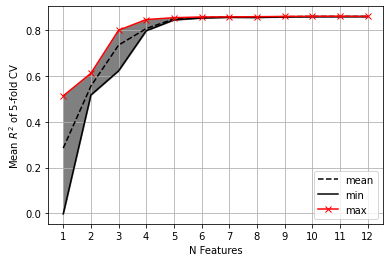

In [47]:
best_features_lat_lon = seq_feature_importance(selected_features_lat_lon, train_feat_df_unscaled)

In [ ]:
# Best features when including lat, lon, and source_receiver_distance_logkm. Do not include receiver_back_azimith
# ['amp_01.0',
#  'source_longitude',
#  'amp_12.0',
#  'source_receiver_distance_logkm',
#  'amp_02.0',
#  'signal_dominant_amplitude',
#  'amp_ratio_01.0',
#  'source_latitude',
#  'amp_08.0',
#  'amp_18.0',
#  'source_depth_km',
#  'signal_max_amplitude',
#  'signal_variance']

In [48]:
best_features_lat_lon

['amp_01.0',
 'source_longitude',
 'amp_12.0',
 'source_latitude',
 'amp_02.0',
 'signal_dominant_amplitude',
 'amp_ratio_01.0',
 'source_depth_km',
 'amp_18.0',
 'amp_08.0',
 'signal_max_amplitude',
 'signal_variance']

iteration 0
[]
signal_dominant_amplitude 0.361415397638428
signal_max_amplitude 0.332138022807809
signal_variance 0.36722909917133123
source_receiver_distance_logkm 0.07003698751961576
source_depth_km -0.002566205699170765
receiver_back_azimuth 0.08457024057962974
amp_01.0 0.5125217967966403
amp_02.0 0.4966748652140286
amp_12.0 0.309080679007558
amp_08.0 0.37218674560055665
amp_18.0 0.2837006274041624
amp_ratio_01.0 0.23155785160544454
iteration 1
['amp_01.0']
signal_dominant_amplitude 0.5425272420284549
signal_max_amplitude 0.544037270626766
signal_variance 0.5529420621697435
source_receiver_distance_logkm 0.608020238946383
source_depth_km 0.5540380480898178
receiver_back_azimuth 0.5608065916677145
amp_02.0 0.546344984922477
amp_12.0 0.5610880189158686
amp_08.0 0.5490115072458158
amp_18.0 0.5676121218838382
amp_ratio_01.0 0.5165755726066177
iteration 2
['amp_01.0', 'source_receiver_distance_logkm']
signal_dominant_amplitude 0.7785605354287168
signal_max_amplitude 0.77832357526162
sign

['amp_01.0',
 'source_receiver_distance_logkm',
 'signal_variance',
 'receiver_back_azimuth',
 'signal_max_amplitude',
 'amp_ratio_01.0',
 'amp_02.0',
 'source_depth_km',
 'amp_12.0',
 'amp_08.0',
 'amp_18.0',
 'signal_dominant_amplitude']

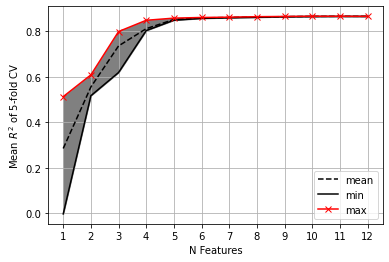

In [51]:
best_features_sr = seq_feature_importance(selected_features_sr, train_feat_df_unscaled)
best_features_sr

In [53]:
# All selected features with lat lon result
selected_feat_lat_lon_cv = svr_cv(train_feat_df_unscaled[selected_features_lat_lon], train_y, folds)
print(selected_feat_lat_lon_cv)
print(np.mean(selected_feat_lat_lon_cv))

[0.85261839 0.8663151  0.84702965 0.86432859 0.86610084]
0.8592785154979289


In [55]:
# Top 5 features with lat lon 
top_feat_lat_lon_cv = svr_cv(train_feat_df_unscaled[best_features_lat_lon[0:5]], train_y, folds)
print(top_feat_lat_lon_cv )
print(np.mean(top_feat_lat_lon_cv))

[0.85601257 0.85428622 0.83221918 0.86273905 0.8638986 ]
0.8538311226990606


In [54]:
# All selected features with sr distance and back azimuth
selected_feat_sr_cv = svr_cv(train_feat_df_unscaled[selected_features_sr], train_y, folds)
print(selected_feat_sr_cv)
print(np.mean(selected_feat_sr_cv))

[0.86646041 0.87085908 0.85056596 0.86420231 0.87251547]
0.8649206449320179


In [56]:
# Top 5 selected features with sr distance and back azimuth
top_feat_sr_cv = svr_cv(train_feat_df_unscaled[best_features_sr[0:5]], train_y, folds)
print(top_feat_sr_cv )
print(np.mean(top_feat_sr_cv))

[0.8625729  0.85862406 0.8334618  0.86211995 0.86891574]
0.8571388883281463


In [25]:
selected_feat_df = train_feat_df.copy()[all_selected_features]
selected_feat_df.loc[:, "magnitude"] = train_y
corr = selected_feat_df.corr()
corr.style.background_gradient(cmap="coolwarm")

NameError: name 'all_selected_features' is not defined

In [64]:
def add_feat_to_base(base_features, additional_features, all_features_cv=None, top_features_cv=None):

    cv_means = []

    for cf in additional_features:
        feat_list = base_features.copy()
        feat_list.append(cf)
        cv_vals = svr_cv(train_feat_df_unscaled[feat_list], train_y, folds)
        cv_means.append(np.mean(cv_vals))

    plt.scatter(range(len(additional_features)), cv_means, marker="x")
    plt.xticks(range(len(additional_features)), labels=additional_features, rotation=45);
    if all_features_cv is not None:
        plt.axhline(np.mean(all_features_cv))
    if top_features_cv is not None:
        plt.axhline(np.mean(top_features_cv), color="C1")
    plt.show()
    
    return cv_means

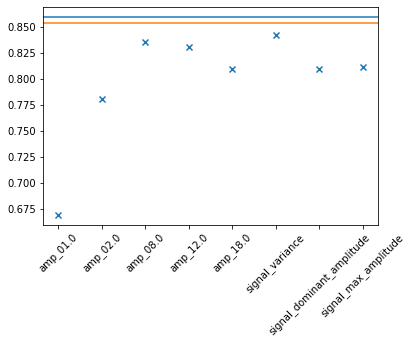

In [88]:
base_features = ['source_longitude', "source_latitude",'source_depth_km', 'amp_ratio_01.0']

correlated_features = ["amp_01.0", 'amp_02.0', "amp_08.0", "amp_12.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude"]

cv_means = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_lat_lon_cv, 
                           top_features_cv=top_feat_lat_lon_cv)

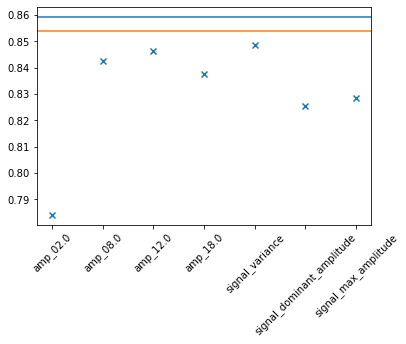

In [89]:
base_features = ['source_longitude', "source_latitude",'source_depth_km', 'amp_ratio_01.0', "amp_01.0"]

correlated_features = ['amp_02.0', "amp_08.0", "amp_12.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude"]

cv_means_amp01  = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_lat_lon_cv, 
                           top_features_cv=top_feat_lat_lon_cv)

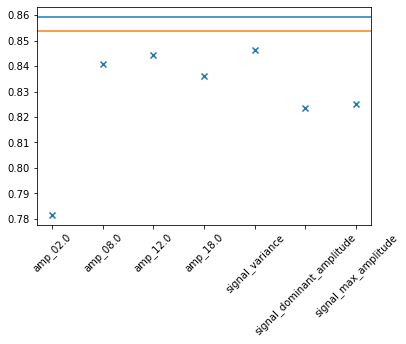

In [90]:
base_features = ['source_longitude', "source_latitude",'amp_ratio_01.0', "amp_01.0"]

correlated_features = ['amp_02.0', "amp_08.0", "amp_12.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude"]

cv_means_nodepth = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_lat_lon_cv, 
                           top_features_cv=top_feat_lat_lon_cv)

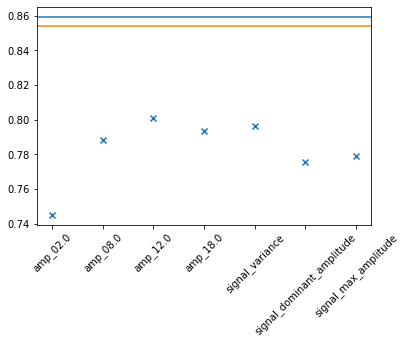

In [91]:
base_features = ['source_longitude','amp_ratio_01.0', "amp_01.0"]

correlated_features = ['amp_02.0', "amp_08.0", "amp_12.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude"]

cv_means_nodepth_nolat = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_lat_lon_cv, 
                           top_features_cv=top_feat_lat_lon_cv)

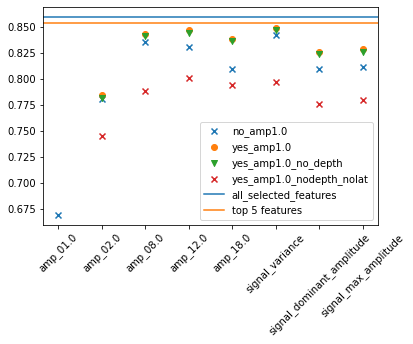

In [92]:
correlated_features = ["amp_01.0", 'amp_02.0', "amp_08.0", "amp_12.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude"]

plt.scatter( range(0,len(correlated_features)), cv_means, marker="x", label="no_amp1.0")
plt.scatter( range(1,len(correlated_features)), cv_means_amp01, marker="o", label="yes_amp1.0")
plt.scatter( range(1,len(correlated_features)), cv_means_nodepth, marker="v", label="yes_amp1.0_no_depth")
plt.scatter( range(1,len(correlated_features)), cv_means_nodepth_nolat, marker="x", label="yes_amp1.0_nodepth_nolat")

plt.xticks(range(len(correlated_features)), labels=correlated_features, rotation=45);
plt.axhline(np.mean(selected_feat_lat_lon_cv), label="all_selected_features")
plt.axhline(np.mean(top_feat_lat_lon_cv), color="C1", label="top 5 features")
plt.legend();

source_receiver_distance_logkm, source_longitude, source_latitude, 
                 source_depth_km, amp_ratio_01.0, amp_01.0, and signal_variance seem to be able to account for most of the performance gain. Some addition of the other features seems to add the extra percent. Though the other features and signal variance are highly correlated. Using depth doesn't change results. Latitude doesn't add much either.

In [23]:
fewer_features_lat_lon = ['source_longitude', "source_latitude",'amp_ratio_01.0', "amp_01.0", "signal_variance"]
fewer_feat_lat_lon_df = train_feat_df.copy()[fewer_features_lat_lon]
fewer_feat_lat_lon_df.loc[:, "magnitude"] = train_y
corr = fewer_feat_lat_lon_df.corr()
corr.style.background_gradient(cmap="coolwarm")

,source_longitude,source_latitude,amp_ratio_01.0,amp_01.0,signal_variance,magnitude
source_longitude,1.000000,-0.481708,0.288465,0.351187,0.215789,0.178556
source_latitude,-0.481708,1.000000,-0.189727,-0.121837,0.199461,-0.072449
amp_ratio_01.0,0.288465,-0.189727,1.000000,0.606635,0.443622,0.471477
amp_01.0,0.351187,-0.121837,0.606635,1.000000,0.707495,0.718212
signal_variance,0.215789,0.199461,0.443622,0.707495,1.000000,0.613380
magnitude,0.178556,-0.072449,0.471477,0.718212,0.613380,1.000000


In [86]:
fewer_feat_lat_lon_cv = svr_cv(train_feat_df_unscaled[fewer_features_lat_lon], train_y, folds)
print(fewer_feat_lat_lon_cv)
print(np.mean(fewer_feat_lat_lon_cv))

[0.83969258 0.85331533 0.83538041 0.85219042 0.85133066]
0.8463818795338469


## Closer look at features with sr features

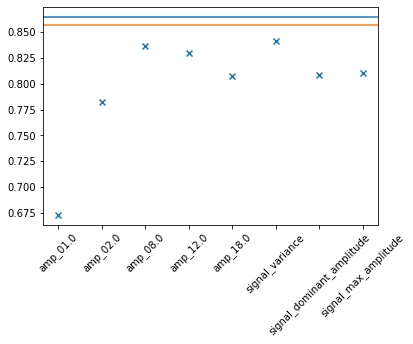

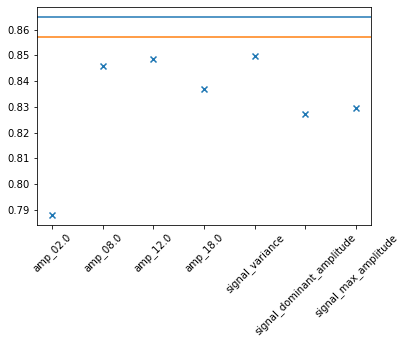

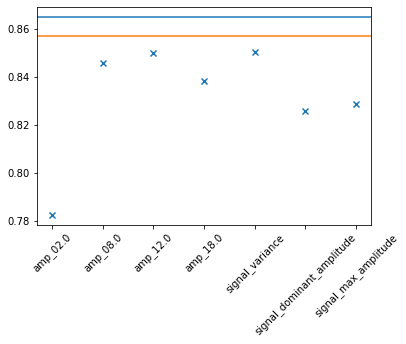

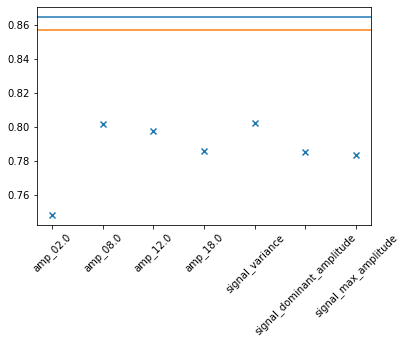

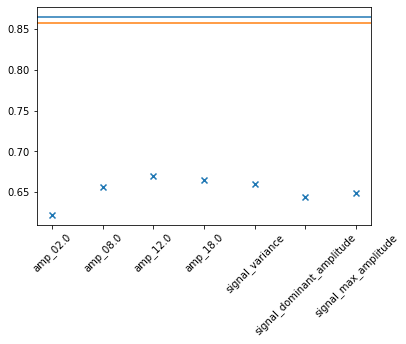

In [93]:
base_features = ['source_receiver_distance_logkm','source_depth_km', "receiver_back_azimuth", 'amp_ratio_01.0']

correlated_features = ["amp_01.0", 'amp_02.0', "amp_08.0", "amp_12.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude"]

cv_means = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

base_features = ['source_receiver_distance_logkm','source_depth_km', "receiver_back_azimuth", 
                 'amp_ratio_01.0', "amp_01.0"]

correlated_features = ['amp_02.0', "amp_08.0", "amp_12.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude"]

cv_means_amp01  = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

base_features = ['source_receiver_distance_logkm', "receiver_back_azimuth",'amp_ratio_01.0', "amp_01.0"]

correlated_features = ['amp_02.0', "amp_08.0", "amp_12.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude"]

cv_means_nodepth = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

base_features = ['source_receiver_distance_logkm','amp_ratio_01.0', "amp_01.0"]

correlated_features = ['amp_02.0', "amp_08.0", "amp_12.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude"]

cv_means_nodepth_noba = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
                           top_features_cv=top_feat_sr_cv)

# SR distance is important 
# base_features = ["receiver_back_azimuth",'amp_ratio_01.0', "amp_01.0"]

# correlated_features = ['amp_02.0', "amp_08.0", "amp_12.0", "amp_18.0", "signal_variance", 
#                        "signal_dominant_amplitude", "signal_max_amplitude"]

# cv_means_nodepth_nosrd = add_feat_to_base(base_features, correlated_features, all_features_cv=selected_feat_sr_cv, 
#                            top_features_cv=top_feat_sr_cv)

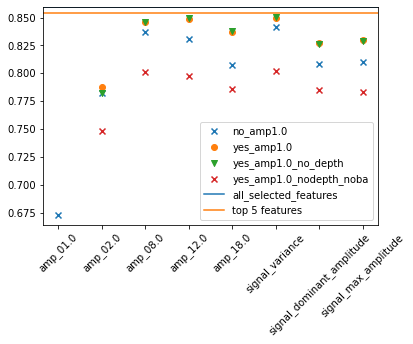

In [96]:
correlated_features = ["amp_01.0", 'amp_02.0', "amp_08.0", "amp_12.0", "amp_18.0", "signal_variance", 
                       "signal_dominant_amplitude", "signal_max_amplitude"]

plt.scatter( range(0,len(correlated_features)), cv_means, marker="x", label="no_amp1.0")
plt.scatter( range(1,len(correlated_features)), cv_means_amp01, marker="o", label="yes_amp1.0")
plt.scatter( range(1,len(correlated_features)), cv_means_nodepth, marker="v", label="yes_amp1.0_no_depth")
plt.scatter( range(1,len(correlated_features)), cv_means_nodepth_noba, marker="x", label="yes_amp1.0_nodepth_noba")
# plt.scatter( range(1,len(correlated_features)), cv_means_nodepth_nosrd, marker="x", label="yes_amp1.0_nodepth_nosr")

plt.xticks(range(len(correlated_features)), labels=correlated_features, rotation=45);
plt.axhline(np.mean(selected_feat_lat_lon_cv), label="all_selected_features")
plt.axhline(np.mean(top_feat_lat_lon_cv), color="C1", label="top 5 features")
plt.legend();

In [22]:
fewer_features_sr = ['source_receiver_distance_logkm', "receiver_back_azimuth",'amp_ratio_01.0', 
                          "amp_01.0", "signal_variance"]
fewer_feat_sr_df = train_feat_df.copy()[fewer_features_sr]
fewer_feat_sr_df.loc[:, "magnitude"] = train_y
corr = fewer_feat_sr_df.corr()
corr.style.background_gradient(cmap="coolwarm")

,source_receiver_distance_logkm,receiver_back_azimuth,amp_ratio_01.0,amp_01.0,signal_variance,magnitude
source_receiver_distance_logkm,1.000000,0.225469,-0.144718,-0.237705,-0.566081,0.110064
receiver_back_azimuth,0.225469,1.000000,-0.189199,-0.289311,-0.131032,-0.190534
amp_ratio_01.0,-0.144718,-0.189199,1.000000,0.606635,0.443622,0.471477
amp_01.0,-0.237705,-0.289311,0.606635,1.000000,0.707495,0.718212
signal_variance,-0.566081,-0.131032,0.443622,0.707495,1.000000,0.613380
magnitude,0.110064,-0.190534,0.471477,0.718212,0.613380,1.000000


In [98]:
fewer_feat_sr_cv = svr_cv(train_feat_df_unscaled[fewer_features_sr], train_y, folds)
print(fewer_feat_sr_cv)
print(np.mean(fewer_feat_sr_cv))

[0.85522096 0.85415076 0.84245395 0.84925675 0.85169269]
0.8505550194137008


## Default C, gamma, and epsilon seem to work well for SVR with RBF

In [99]:
#C_range = [1.0]#np.logspace(-2, 10, 5)
gamma_range = [7.4e-05, 0.1, 0.2, 0.3, 0.4, 5e-1, 1, "scale", "auto"]#np.logspace(-9, 3, 5)
epsilon_range = [5e-3, 1e-2, 5e-2, 1e-1, 2e-1]
param_grid = {"svr__gamma":gamma_range,  "svr__epsilon":epsilon_range} #"svr__C":C_range,
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ('svr', SVR(C=1.0))])
grid = GridSearchCV(pipeline, param_grid=param_grid, scoring="r2", n_jobs=3, cv=folds)
svr_cv_results = grid.fit(train_feat_df_unscaled[fewer_features_sr], train_y)

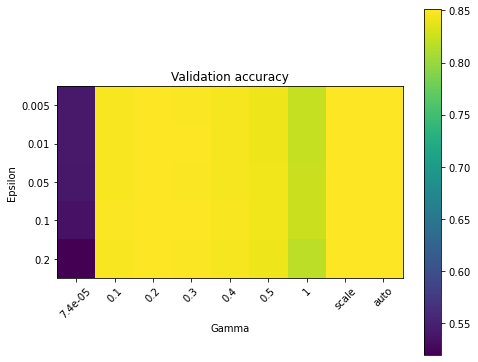

In [100]:
scores = grid.cv_results_["mean_test_score"].reshape(len(epsilon_range), len(gamma_range))
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.viridis,
    #norm=MidpointNormalize(vmin=0.2, midpoint=0.92),
)
plt.xlabel("Gamma")
plt.ylabel("Epsilon")
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(epsilon_range)), epsilon_range)
plt.title("Validation accuracy")
plt.show()

## XGBoost

Try more hyperparameters, try with limited features

In [54]:
from xgboost import XGBRegressor
from xgboost import DMatrix
import xgboost

In [34]:
from sklearn.utils.fixes import loguniform
import scipy.stats as stats

In [77]:
xgb = XGBRegressor(objective='reg:squarederror', eval_metric='rmse').fit(
                                    train_feat_matrix_unscaled[folds[0][0]], train_y[folds[0][0]])
xgb.score(train_feat_matrix_unscaled[folds[0][1]], train_y[folds[0][1]])

0.8436004781775079

In [81]:
train_feat_df.columns[43]

'source_depth_km'

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

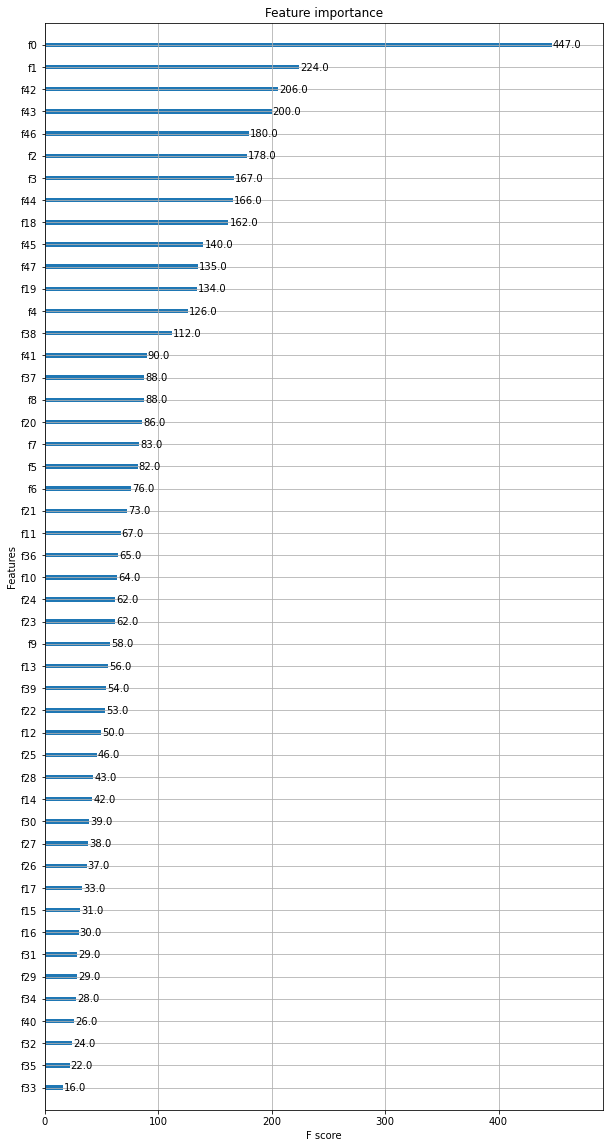

In [78]:
fig, ax = plt.subplots(1, figsize=(10, 20))
xgboost.plot_importance(xgb, ax=ax)

In [93]:
feat_bool = np.isin(train_feat_df.columns, fewer_features_sr)
xgb = XGBRegressor(objective='reg:squarederror', eval_metric='rmse').fit(
                                    train_feat_matrix_unscaled[folds[0][0]][:, feat_bool], train_y[folds[0][0]])
xgb.score(train_feat_matrix_unscaled[folds[0][1]][:, feat_bool], train_y[folds[0][1]])

0.8267700491252781

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

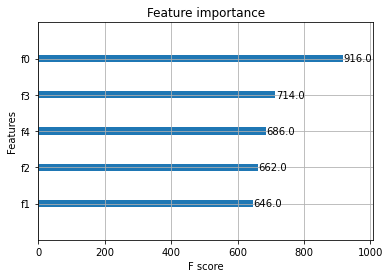

In [95]:
xgboost.plot_importance(xgb)

In [96]:
feat_bool = np.isin(train_feat_df.columns, fewer_features_lat_lon)
xgb = XGBRegressor(objective='reg:squarederror', eval_metric='rmse').fit(
                                    train_feat_matrix_unscaled[folds[0][0]][:, feat_bool], train_y[folds[0][0]])
xgb.score(train_feat_matrix_unscaled[folds[0][1]][:, feat_bool], train_y[folds[0][1]])

0.828211006778645

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

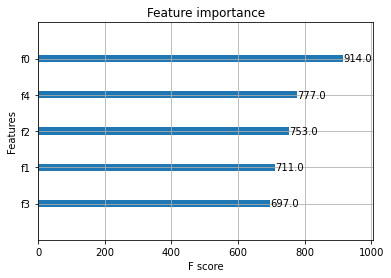

In [97]:
xgboost.plot_importance(xgb)

In [99]:
grid_params = {'max_depth': [1, 2, 3, 5, 10], 
          'eta': [0.05, 0.1, 0.2, 0.3, 0.5],
          'gamma': [0, 0.2, 0.5, 1, 1.5, 2, 5], 
         'min_child_weight':[0, 0.5, 1, 2], 
         'max_delta_step': [0, 1, 2], 
          'subsample': [0.5, 1]}

params = {'max_depth': stats.randint(3, 18),
          'gamma': stats.uniform(0, 5),
          'learning_rate': loguniform(1e-2, 1e0),
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree':stats.uniform(0.5,1),
          'min_child_weight':stats.randint(0, 10), 
          'n_estimators': [100, 250, 500, 750],
          }
    
# params = {'objective': 'reg:squarederror'}
# params['eval_metric'] = 'rmse'
# params['nthread'] = 2

In [100]:
xgb = XGBRegressor(objective='reg:squarederror', eval_metric='rmse') #, topnthread=2
# grid_search = GridSearchCV(xgb, param_grid=grid_params, scoring="r2", 
#                            n_jobs=3, cv=folds).fit(train_feat_matrix_unscaled, train_y)
rand_search = RandomizedSearchCV(xgb, param_distributions=params, scoring="r2", 
                           n_jobs=3, cv=folds).fit(train_feat_matrix_unscaled[:, feat_bool], train_y)

/home/armstrong/anaconda3/envs/ngb-swarm/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/armstrong/anaconda3/envs/ngb-swarm/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/armstrong/anaconda3/envs/ngb-swarm/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/armstrong/anaconda3/envs/ngb-swarm/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 


In [102]:
rand_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6307141761406282,
             enable_categorical=False, eval_metric='rmse',
             gamma=1.2640923999611409, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.028336662205774507,
             max_delta_step=0, max_depth=14, min_child_weight=7, missing=nan,
             monotone_constraints='()', n_estimators=250, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.6,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
# {'eta': 0.1,
#  'gamma': 0.5,
#  'max_delta_step': 1,
#  'max_depth': 5,
#  'min_child_weight': 0.5}

# 0.8620877350386309

In [104]:
rand_search.best_params_

{'colsample_bytree': 0.6307141761406282,
 'gamma': 1.2640923999611409,
 'learning_rate': 0.028336662205774507,
 'max_depth': 14,
 'min_child_weight': 7,
 'n_estimators': 250,
 'subsample': 0.6}

In [103]:
rand_search.best_score_

0.8161718940077647

In [360]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df.sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_eta,param_gamma,param_max_delta_step,param_max_depth,param_min_child_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
22,0.864295,0.024485,0.001776,0.000027,0.1,0.5,1,5,1,"{'eta': 0.1, 'gamma': 0.5, 'max_delta_step': 1...",0.851508,0.876585,0.859669,0.857501,0.865175,0.862088,0.008468,1
21,0.848176,0.012971,0.001773,0.000039,0.1,0.5,1,5,0.5,"{'eta': 0.1, 'gamma': 0.5, 'max_delta_step': 1...",0.851508,0.876585,0.859669,0.857501,0.865175,0.862088,0.008468,1
23,0.915045,0.057268,0.001930,0.000157,0.1,0.5,1,5,2,"{'eta': 0.1, 'gamma': 0.5, 'max_delta_step': 1...",0.850719,0.875802,0.856524,0.855749,0.866509,0.861061,0.008975,3
143,0.824279,0.018338,0.001649,0.000033,0.2,0.5,1,5,2,"{'eta': 0.2, 'gamma': 0.5, 'max_delta_step': 1...",0.849515,0.871540,0.853172,0.856708,0.866093,0.859406,0.008196,4
9,0.835923,0.016201,0.001744,0.000031,0.1,0.5,0,5,0.5,"{'eta': 0.1, 'gamma': 0.5, 'max_delta_step': 0...",0.848715,0.873781,0.859140,0.856353,0.859023,0.859402,0.008130,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470,0.171351,0.001210,0.001447,0.000025,0.5,5,1,1,2,"{'eta': 0.5, 'gamma': 5, 'max_delta_step': 1, ...",0.728570,0.771963,0.744521,0.754600,0.749059,0.749743,0.014095,475
468,0.171236,0.000884,0.001473,0.000046,0.5,5,1,1,0.5,"{'eta': 0.5, 'gamma': 5, 'max_delta_step': 1, ...",0.728570,0.771963,0.744521,0.754600,0.749059,0.749743,0.014095,475
458,0.170862,0.002862,0.001508,0.000085,0.5,5,0,1,2,"{'eta': 0.5, 'gamma': 5, 'max_delta_step': 0, ...",0.721374,0.747341,0.719273,0.739084,0.738465,0.733107,0.010918,478
456,0.171211,0.002286,0.001470,0.000027,0.5,5,0,1,0.5,"{'eta': 0.5, 'gamma': 5, 'max_delta_step': 0, ...",0.721374,0.747341,0.719273,0.739084,0.738465,0.733107,0.010918,478


In [55]:
num_round = 100
dtrain = DMatrix(train_feat_matrix_unscaled, label=train_y, feature_names=train_feat_df_unscaled.columns)
bst_cv = xgboost.cv(param, dtrain, num_round, folds=folds, early_stopping_rounds=3, 
               callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)])

NameError: name 'param' is not defined

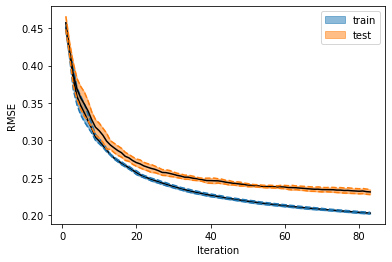

In [330]:
x_ticks = range(1, len(bst_cv)+1)
plt.plot(x_ticks, bst_cv["train-rmse-mean"], color="k")
plt.plot(x_ticks, bst_cv["train-rmse-mean"]+bst_cv["train-rmse-std"], linestyle="--", color="C0")
plt.plot(x_ticks, bst_cv["train-rmse-mean"]-bst_cv["train-rmse-std"], linestyle="--", color="C0")
plt.fill_between(x_ticks,bst_cv["train-rmse-mean"]+bst_cv["train-rmse-std"], 
                 bst_cv["train-rmse-mean"]-bst_cv["train-rmse-std"], color="C0", alpha=0.5, label="train")

plt.plot(x_ticks, bst_cv["test-rmse-mean"], color="k")
plt.plot(x_ticks, bst_cv["test-rmse-mean"]+bst_cv["test-rmse-std"], linestyle="--", color="C1")
plt.plot(x_ticks, bst_cv["test-rmse-mean"]-bst_cv["test-rmse-std"], linestyle="--", color="C1")
plt.fill_between(x_ticks, bst_cv["test-rmse-mean"]+bst_cv["test-rmse-std"], 
                 bst_cv["test-rmse-mean"]-bst_cv["test-rmse-std"], color="C1", alpha=0.5, label="test")

plt.ylabel("RMSE")
plt.xlabel("Iteration")

#plt.xticks(x_ticks)
plt.legend()